In [24]:
#import all the required libraries
import pandas
import pandas as pd
import scipy.io
import numpy as np
import os
import shutil
import random
import tensorflow as tf
from keras.utils.vis_utils import plot_model
import cv2 as cv
import matplotlib.pyplot as plt
#import efficientnet.keras as efn


In [ ]:
#mounts google drive 
from google.colab import drive
drive.mount('/content/drive')

In [3]:
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 22 kB/s 
     |████████████████████████████████| 6.0 MB 13.8 MB/s 
     |████████████████████████████████| 1.7 MB 43.6 MB/s 
     |████████████████████████████████| 439 kB 62.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully u

In [4]:
tf.config.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#Processing Training Data into trainable format
def process_train_data(image_height=256,image_width=256,margin=16):
    '''

    :param image_height: Desired height of image in pixels, default to 256
    :param image_width: Desired width of image in pixels,defaults to 256
    :param margin: Margin to be added around bounding box,defaults to 16
    :return: saved processed image files into the destination folder
    '''

    cars_annos = scipy.io.loadmat('car_devkit/devkit/cars_train_annos.mat') #loads the matlab file
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations) #transposes the row data to column data


    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations: #iterating over each array 
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)


    src_folder =r'/content/drive/MyDrive/Stanford cars/cars_train' 
    num_samples = len(fnames)


    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]


        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)

        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = margin
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print("{} -> {}".format(fname, label))


        dst_folder = r'/content/drive/MyDrive/Stanford cars/Data/Train_1'


        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(image_width, image_height))
        cv.imwrite(dst_path, dst_img)

In [ ]:
process_train_data()

In [ ]:
#Process Test data into proper format
def process_test_data(image_height=256,image_width=256,margin=16):
    '''

    :param image_height: Desired height of image in pixels, default to 256
    :param image_width: Desired width of image in pixels,defaults to 256
    :param margin: Margin to be added around bounding box,defaults to 16
    :return: saved processed image files into the destination folder
    '''

    cars_annos = scipy.io.loadmat('/content/drive/MyDrive/Stanford cars/devkit/cars_test_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    bboxes = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)


    src_folder = r'/content/drive/MyDrive/Stanford cars/cars_test'
    dst_folder = r'/content/drive/MyDrive/Stanford cars/Data/test'
    num_samples = len(fnames)



    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = margin
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print(fname)

        dst_path = os.path.join(dst_folder, fname)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(image_height,image_width))
        cv.imwrite(dst_path, dst_img)

In [ ]:
process_test_data()

In [6]:
#Does a training-validation split
#Builds a dataset along with labels
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Stanford cars/Data/Train_1",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(256,256),
    batch_size=16
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Stanford cars/Data/Train_1",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(256,256),
    batch_size=16
)


Found 8144 files belonging to 1 classes.
Using 6516 files for training.
Found 8144 files belonging to 1 classes.
Using 1628 files for validation.


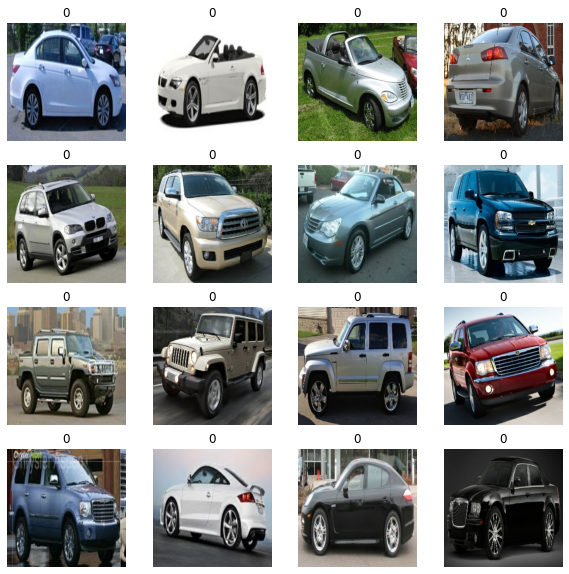

In [7]:
#example plot of standardized images 
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
#Performs data augmentation to prevent overfitting
#Introduces randomness to the image data so the model generalizes well with newer images
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

In [9]:
#applying the augmentation
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [10]:
#defining model architecture
def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Entry block
    x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    return tf.keras.Model(inputs, outputs)




In [11]:
model = make_model(input_shape=(256,256,3), num_classes=196)


In [12]:
from tensorflow.python.keras.utils.vis_utils import model_to_dot

from tensorflow.python.keras.utils.vis_utils import plot_model

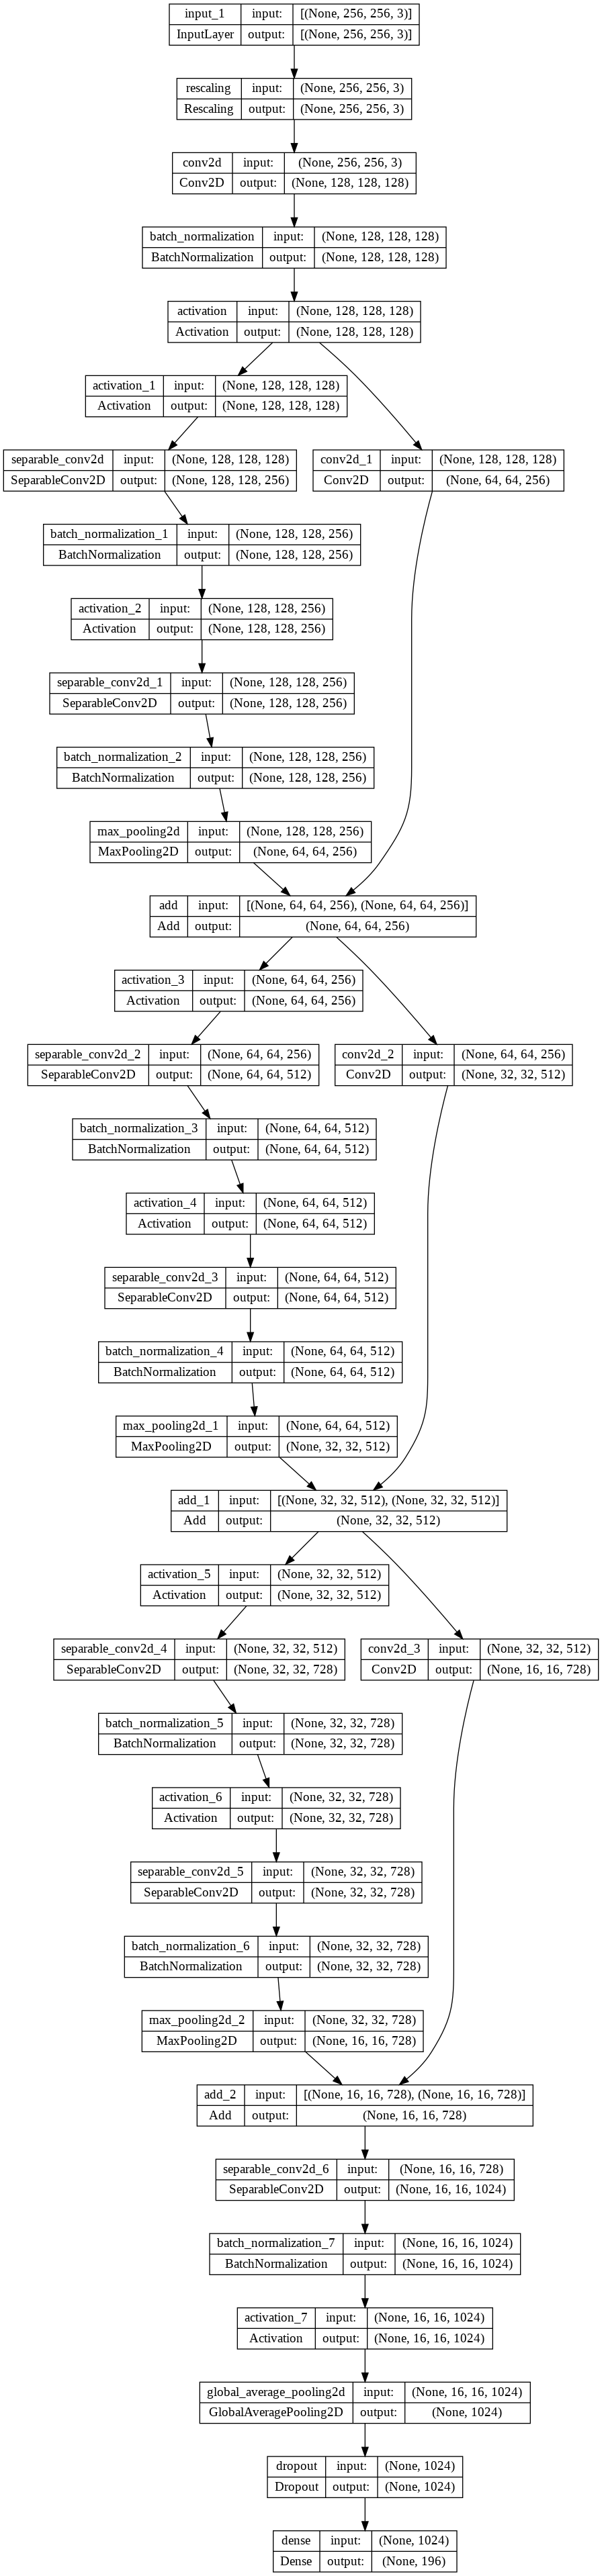

In [13]:
#plots the model architecture
tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True)

In [14]:
#loads a previously trained model if any
model_v2 = tf.keras.models.load_model('/content/drive/MyDrive/Stanford cars/Models/Model002.h5',compile=True)

In [15]:
model_v2

In [16]:
epochs = 25

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

In [17]:
#compiling and fitting the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    augmented_train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

In [18]:
#fitting the second model
model_v2.fit(augmented_train_ds,epochs=epochs,callbacks=callbacks,validation_data=val_ds)

Epoch 1/25


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
408/408 [==============================] - ETA: 0s - loss: 0.2782 - accuracy: 0.9820

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
408/408 [==============================] - 917s 2s/step - loss: 0.2782 - accuracy: 0.9820 - val_loss: 4.1641e-06 - val_accuracy: 1.0000
Epoch 2/25
408/408 [==============================] - 246s 602ms/step - loss: 2.4843e-06 - accuracy: 1.0000 - val_loss: 1.2709e-05 - val_accuracy: 1.0000
Epoch 3/25
408/408 [==============================] - 249s 610ms/step - loss: 1.6728e-06 - accuracy: 1.0000 - val_loss: 1.1842e-05 - val_accuracy: 1.0000
Epoch 4/25
408/408 [==============================] - 249s 610ms/step - loss: 1.0057e-06 - accuracy: 1.0000 - val_loss: 1.0184e-05 - val_accuracy: 1.0000
Epoch 5/25
408/408 [==============================] - 249s 

In [19]:
#def build_finetune_model(base_model, dropout, num_classes):

#    x = base_model.output

#    x = tf.keras.layers.AveragePooling2D((5, 5), name='avg_pool')(x)
#    x = tf.keras.layers.Flatten()(x)
#    x = tf.keras.layers.Dropout(dropout)(x)
#    predictions = tf.keras.layers.Dense(num_classes, activation='softmax', name='finalfc')(x)

#    finetune_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

#    return finetune_model

In [22]:
#base_model = efn.EfficientNetB3(weights='imagenet',include_top=False,input_shape=(224,224,3))

In [25]:
#snapshot = SnapshotCallbackBuilder(nb_epochs=25,nb_snapshots=1,init_lr=1e-3)
#finetune_model = build_finetune_model(base_model,dropout=0.2,num_classes=196)
#finetune_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#finetune_model.fit(train_ds,validation_data=val_ds,steps_per_epoch=150,
                   #epochs=epochs,verbose=2,validation_steps=55,callbacks=callbacks)

In [26]:
#saves the model
model_v2.save('/content/drive/MyDrive/Stanford cars/Models/Model003.h5')

In [30]:
model_v2.history

In [28]:
#loading a test image
rgb_image = cv.imread('/content/drive/MyDrive/Stanford cars/Data/test/00001.jpg')
rgb_img = cv.resize(cv.cvtColor(rgb_image, cv.COLOR_BGR2RGB)/255,(256,256))
rgb_img = np.expand_dims(rgb_img, 0)

In [41]:
#loading the model
model_2=tf.keras.models.load_model('/content/drive/MyDrive/Stanford cars/Models/Model002.h5')

In [50]:
#predicting the label of an image
#preds = model_v2.predict(rgb_img)
#preds

In [48]:
#names of classes
scipy.io.loadmat('/content/drive/MyDrive/Stanford cars/devkit/cars_meta.mat')['class_names']

array([[array(['AM General Hummer SUV 2000'], dtype='<U26'),
        array(['Acura RL Sedan 2012'], dtype='<U19'),
        array(['Acura TL Sedan 2012'], dtype='<U19'),
        array(['Acura TL Type-S 2008'], dtype='<U20'),
        array(['Acura TSX Sedan 2012'], dtype='<U20'),
        array(['Acura Integra Type R 2001'], dtype='<U25'),
        array(['Acura ZDX Hatchback 2012'], dtype='<U24'),
        array(['Aston Martin V8 Vantage Convertible 2012'], dtype='<U40'),
        array(['Aston Martin V8 Vantage Coupe 2012'], dtype='<U34'),
        array(['Aston Martin Virage Convertible 2012'], dtype='<U36'),
        array(['Aston Martin Virage Coupe 2012'], dtype='<U30'),
        array(['Audi RS 4 Convertible 2008'], dtype='<U26'),
        array(['Audi A5 Coupe 2012'], dtype='<U18'),
        array(['Audi TTS Coupe 2012'], dtype='<U19'),
        array(['Audi R8 Coupe 2012'], dtype='<U18'),
        array(['Audi V8 Sedan 1994'], dtype='<U18'),
        array(['Audi 100 Sedan 1994'], dtype='<U